Code for risk analysis

In [ ]:
import os

risks_file_path = '/path/to/risks.csv' # Path to the risks file
filings_path_10K = '/path/to/10-K/'    # Path to the 10-K files

df = pd.read_csv(risks_file_path)
dir, _, files = next(os.walk(filings_path_10K))

In [ ]:
df.head()

,Risk,Keyword
0,financial,anti-takeover provisions
1,financial,anti-takeover provision
2,financial,reserves
3,financial,bank debt financial revolver
4,financial,capital expenditure


In [ ]:
df['Risk'].unique()

array(['financial', 'other-idiosyncratic', 'legal and regulatory',
       'other-systematic', 'tax'], dtype=object)

In [ ]:
import json
from math import log2
from tqdm.notebook import tqdm

risk_data = {'filing': [], 'CIK': [], 'year': []}

columns = df['Risk'].unique()

for col in columns:
  risk_data[col] = []

for file in tqdm(files):
  fp = open(f'{dir}/{file}', 'r')
  filing = json.load(fp)

  # Get the text of the 10-K which contains the risk data
  text = ''
  if 'item_1A' in filing:
    text += re.sub(r'\n', ' ', filing['item_1A'].lower()) # Risk Factors
  if 'item_7A' in filing:
    text += re.sub(r'\n', ' ', filing['item_7A'].lower()) # Quantitative and Qualitative Disclosures About Market Risk

  file = file.strip('.json')
  risk_data['filing'].append(file)
  risk_data['CIK'].append(file.split('_')[1])
  risk_data['year'].append(file.split('_')[-1].split('-')[1])

  for col in columns:
    Nr = 0
    for risk in df[df['Risk'] == col]['Keyword'].values:
      Nr += text.count(risk)

    # Risk metric is defined as log2(1 + Nr) where Nr is the number of times the keyword appears in the text of the filing
    risk_data[col].append(log2(1+Nr))

  0%|          | 0/1014 [00:00<?, ?it/s]

In [ ]:
output_path = './files/risk_metric.csv'

out_df = pd.DataFrame(risk_data).sort_values(['CIK', 'year'])
out_df.to_csv(output_path, index=False)
out_df.head()

,filing,CIK,year,financial,other-idiosyncratic,legal and regulatory,other-systematic,tax
469,10K_1001601_20151231_0001013762-16-001482,1001601,16,6.339850,9.481799,6.266787,7.294621,3.000000
476,10K_1001601_20161231_0001493152-17-004179,1001601,17,5.285402,9.562242,5.247928,7.643856,2.000000
489,10K_1001601_20171231_0001493152-18-004538,1001601,18,5.247928,9.108524,5.781360,8.000000,4.087463
501,10K_1001601_20181231_0001493152-19-005484,1001601,19,5.169925,9.082149,5.832890,7.971544,3.700440
507,10K_1001601_20191231_0001493152-20-005218,1001601,20,5.459432,9.330917,6.426265,8.076816,4.247928


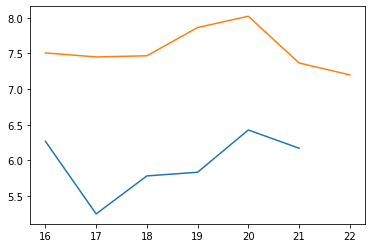

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(out_df[out_df['CIK'] == '1001601']['year'], out_df[out_df['CIK'] == '1001601']['legal and regulatory'])
plt.plot(out_df[out_df['CIK'] == '1433195']['year'], out_df[out_df['CIK'] == '1433195']['legal and regulatory'])